# SD-TSIA210 Machine Learning Project
## Multi-class classification
by Celine Beyrouthy, Bourhan Derknaya, Sahar Kiameh, Karim Reda.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving leaf.csv to leaf.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle

# Neural Networks
#Libraries for MLP
from sklearn.neural_network import MLPClassifier

#Keras libraries for Neural Networks
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras import optimizers, initializers
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
names = ["Class (Species)", "Specimen Number", "Eccentricity", "Aspect Ratio",
         "Elongation", "Solidity", "Stochastic Convexity", "Isoperimetric Factor",
         "Maximal Indentation Depth", "Lobedness", "Average Intensity",
         "Average Contrast", "Smoothness", "Third moment", "Uniformity", "Entropy"]
df = pd.read_csv('leaf.csv', names=names)
df.describe()

,Class (Species),Specimen Number,Eccentricity,Aspect Ratio,Elongation,Solidity,Stochastic Convexity,Isoperimetric Factor,Maximal Indentation Depth,Lobedness,Average Intensity,Average Contrast,Smoothness,Third moment,Uniformity,Entropy
count,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000
mean,18.544118,6.282353,0.719854,2.440210,0.513760,0.904158,0.943793,0.531234,0.037345,0.523845,0.051346,0.124535,0.017670,0.005928,0.000387,1.162630
std,11.152514,3.462779,0.208311,2.599043,0.195583,0.114639,0.115047,0.217532,0.038575,1.039639,0.035965,0.051860,0.013755,0.005294,0.000431,0.584854
min,1.000000,1.000000,0.117080,1.006600,0.107610,0.485490,0.396490,0.078376,0.002837,0.001464,0.005022,0.033415,0.001115,0.000229,0.000007,0.169400
25%,9.000000,3.000000,0.550622,1.211300,0.349623,0.890667,0.966230,0.346818,0.009521,0.016500,0.022843,0.083362,0.006901,0.002080,0.000102,0.718900
50%,15.000000,6.000000,0.763450,1.570750,0.501855,0.948130,0.992980,0.579160,0.023860,0.103615,0.042087,0.119375,0.014050,0.004447,0.000239,1.077450
75%,29.000000,9.000000,0.895097,2.343100,0.633373,0.976897,1.000000,0.700712,0.047834,0.416433,0.073046,0.163795,0.026127,0.008307,0.000516,1.554575
max,36.000000,16.000000,0.998710,19.038000,0.948340,0.993880,1.000000,0.858160,0.198980,7.206200,0.190670,0.280810,0.073089,0.029786,0.002936,2.708500


Notice that we don't have any missing data, so no need to 'clean' the data, or certain features.

svm, random forest, adaboost, decision tree, nn.

In [ ]:
df.columns

Index(['Class (Species)', 'Specimen Number', 'Eccentricity', 'Aspect Ratio',
       'Elongation', 'Solidity', 'Stochastic Convexity',
       'Isoperimetric Factor', 'Maximal Indentation Depth', 'Lobedness',
       'Average Intensity', 'Average Contrast', 'Smoothness', 'Third moment',
       'Uniformity', 'Entropy'],
      dtype='object')

In [ ]:
X = df[df.columns[2:]]
y = df[df.columns[0]]

In [ ]:
print("There are only {} different species figuring in our dataset, despite having 40 different plant species.".format(y.unique().shape[0]))
print("We are working with", X.shape[0],"entries, having", X.shape[1], "features each.")

There are only 30 different species figuring in our dataset, despite having 40 different plant species.
We are working with 340 entries, having 14 features each.


In [ ]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36])

After checking what are the figuring species, we found out that we only have species from 1 to 15 and from 22 to 36, which corresponds to the species that exhibit simple leaves.

This explains why 10 species are amiss. It is because complex leaves were not considered in this study, which are usually numbered from 16 to 21 and from 37 to 40.


Let's see how many of each specie do we have in this dataset:

In [ ]:
X

,Eccentricity,Aspect Ratio,Elongation,Solidity,Stochastic Convexity,Isoperimetric Factor,Maximal Indentation Depth,Lobedness,Average Intensity,Average Contrast,Smoothness,Third moment,Uniformity,Entropy
0,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,0.114880,0.208610,0.041703,0.013344,0.000820,2.02810
336,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,0.141220,0.218300,0.045488,0.012002,0.001515,2.40590
337,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,0.097663,0.207030,0.041101,0.016123,0.000453,1.69350
338,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,0.050389,0.135850,0.018121,0.006190,0.000265,1.15260


In [ ]:
counts = {}
for i in range(y.shape[0]):
  if y[i] in counts.keys():
      counts[y[i]] += 1 
  else:
       counts[y[i]] = 1
counts

{1: 12,
 2: 10,
 3: 10,
 4: 8,
 5: 12,
 6: 8,
 7: 10,
 8: 11,
 9: 14,
 10: 13,
 11: 16,
 12: 12,
 13: 13,
 14: 12,
 15: 10,
 22: 12,
 23: 11,
 24: 13,
 25: 9,
 26: 12,
 27: 11,
 28: 12,
 29: 12,
 30: 12,
 31: 11,
 32: 11,
 33: 11,
 34: 11,
 35: 11,
 36: 10}

Analyzing that output, we notice that it is the same as the second feature column provided. We confirm that the provided column that is named Specimen Number states the order number of available leaves of each kind. 

For instance, we have 11 entries that are from the specie 31, which corresponds to the Podocarpus specie.

Thus we conclude that the Specimen Number attribute is not a feature, but it is an ordering entry. But, we can make use of it by relating each specie with its frequency of appearance. 

So we create a feature that corresponds to the usual availability of each specie, hence we could take it into consideration while predicting. But, this requires an active access to the dataset in order to modify that number everytime we insert a new ground truth entry to our dataset.

Hence:

In [ ]:
X.mean()

Eccentricity                 0.719854
Aspect Ratio                 2.440210
Elongation                   0.513760
Solidity                     0.904158
Stochastic Convexity         0.943793
Isoperimetric Factor         0.531234
Maximal Indentation Depth    0.037345
Lobedness                    0.523845
Average Intensity            0.051346
Average Contrast             0.124535
Smoothness                   0.017670
Third moment                 0.005928
Uniformity                   0.000387
Entropy                      1.162630
dtype: float64

In [ ]:
X.std()

Eccentricity                 0.208311
Aspect Ratio                 2.599043
Elongation                   0.195583
Solidity                     0.114639
Stochastic Convexity         0.115047
Isoperimetric Factor         0.217532
Maximal Indentation Depth    0.038575
Lobedness                    1.039639
Average Intensity            0.035965
Average Contrast             0.051860
Smoothness                   0.013755
Third moment                 0.005294
Uniformity                   0.000431
Entropy                      0.584854
dtype: float64

In order to facilitate our data model, we will shift the class values (y) of 22-16 = 6 places, in order to have a continuous range of y values.

This means that we will have $y \in \{1,2,3,...,28,29,30\}$, instead of $y \in \{1,2,3,..,14,15\} \cup \{22,23..,28,29,30\}$.

Let's do it:

In [ ]:
X = df[df.columns[2:]]
y = df[df.columns[0]]
if max(y) > 30:
  y[np.where(y>21)[0]] -= 6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

Another preprocessing step that should be executed is shuffling the data. In fact we can notice that it is ordered by species, so this won't be good for training a neural network for example.

In [ ]:
X, y = shuffle(X,y)

Now let's standardize (center and normalize) our data:

In [ ]:
X = preprocessing.StandardScaler().fit_transform(X)

In [ ]:
X.mean(), X.std()

(9.79608551139844e-18, 1.0)

We have now standardized the data in order to perform multi-class classification correctly. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

## SVC

In [ ]:
parameters = {'kernel':['linear', 'rbf', 'poly'],
              'C': np.linspace(1,100,100),
              'degree': np.linspace(1,10,10)}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,...
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.]),
                         'degree': array([ 1.,

In [ ]:
print("The best kernel is: {} \n The best value for C is: {}".format(clf.best_params_['kernel'],clf.best_params_['C']))
print("The best degree is {}".format(clf.best_params_['degree']))

The best kernel is: linear 
 The best value for C is: 7.0
The best degree is 1.0


In [ ]:
clf = SVC(kernel='linear', C=38)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)
print('Training Score : %s' % score_train)
print('Test Score : %s' % score_test)

Training Score : 0.973568281938326
Test Score : 0.8053097345132744


In [ ]:
y_pred

array([12, 18,  3, 10,  3, 12, 23,  4, 28, 18, 30, 20, 29, 13, 21,  7, 24,
       23, 14, 18, 28, 12, 18, 10, 21, 19, 16,  5,  1, 27,  9, 14, 13, 27,
        5,  2,  6,  5, 19, 18, 16, 12, 18, 16, 23,  8, 18, 18,  7,  2, 22,
       30, 19,  4, 24, 23, 17, 25, 21, 18,  6, 26,  9, 24,  9, 12, 17,  8,
       11, 11, 23, 28,  3,  7, 23, 17, 25, 15, 30, 16, 17, 29, 10,  9,  8,
       17,  2, 15, 11, 11, 26, 20, 27, 13, 30, 22,  7, 23, 28, 11, 30, 13,
       14,  7,  4,  7, 12, 28, 30, 29, 12, 26, 21])

The model is overfitting but performing well on the training and testing sets. 

##Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

score_train = dt.score(X_train, y_train)
score_test = dt.score(X_test, y_test)
print('Training Score : %s' % score_train)
print('Test Score : %s' % score_test)

Training Score : 1.0
Test Score : 0.5132743362831859


The model is overfitting and not giving good predictions when faced with  since the test score is very low and the training score is 1.

##Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

score_train = rf.score(X_train, y_train)
score_test = rf.score(X_test, y_test)
print('Training Score : %s' % score_train)
print('Test Score : %s' % score_test)

Training Score : 1.0
Test Score : 0.672566371681416


We get very accurate predictions but it overfits on the traning data which is why we will adjust our model by tuning the hyperparameters.

In [ ]:
param_range = np.arange(10,100)
train_scoreNum, test_scoreNum = validation_curve(
                                rf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3)

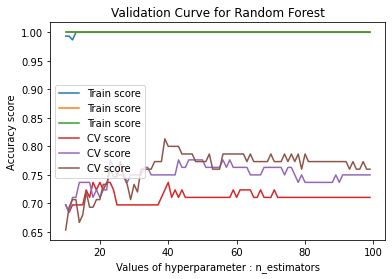

In [ ]:
param_range = np.arange(10,100)
plt.plot(param_range, train_scoreNum, label = "Train score")
plt.plot(param_range, test_scoreNum, label="CV score")
plt.ylabel("Accuracy score")
plt.xlabel("Values of hyperparameter : n_estimators")
plt.title("Validation Curve for Random Forest")
plt.legend()
plt.show()

In this graph, we see that the best value for n_estimators is 30.

In [ ]:
param_range = np.arange(1,10)
train_scoreNum, test_scoreNum = validation_curve(
                                rf,
                                X = X_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = param_range, cv = 3)

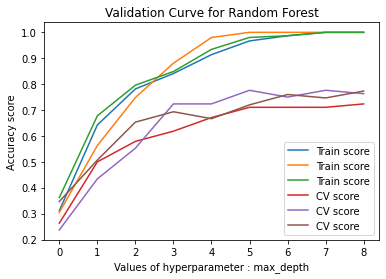

In [ ]:
plt.plot(train_scoreNum, label = "Train score")
plt.plot(test_scoreNum, label="CV score")
plt.ylabel("Accuracy score")
plt.xlabel("Values of hyperparameter : max_depth")
plt.title("Validation Curve for Random Forest")
plt.legend()
plt.show()

We see that the best testing score is reached with a max_depth that equals 7. 

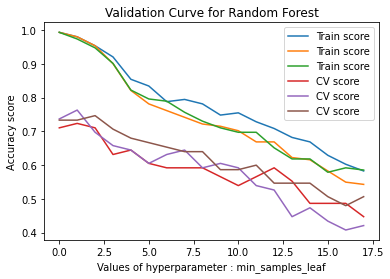

In [ ]:
param_range = np.arange(2,20)
train_scoreNum, test_scoreNum = validation_curve(
                                rf,
                                X = X_train, y = y_train, 
                                param_name = 'min_samples_leaf', 
                                param_range = param_range, cv = 3)
plt.plot(train_scoreNum, label = "Train score")
plt.plot(test_scoreNum, label="CV score")
plt.ylabel("Accuracy score")
plt.xlabel("Values of hyperparameter : min_samples_leaf")
plt.title("Validation Curve for Random Forest")
plt.legend()
plt.show()

We can see that the training and testing scores are decreasing with respect to the value of min_sample_leaf. Therefore, the most favorable value is the default one, 1.

## Optimized Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_depth=7)
rf.fit(X_train, y_train)

score_train = rf.score(X_train, y_train)
score_test = rf.score(X_test, y_test)
print('Training Score : %s' % score_train)
print('Test Score : %s' % score_test)

Training Score : 0.9779735682819384
Test Score : 0.7168141592920354


## AdaBoost Classifier

In [ ]:
adb = AdaBoostClassifier(base_estimator= SVC(kernel='rbf',
                                             gamma=0.001,
                                             C=38),
                         n_estimators=150, algorithm = 'SAMME')
adb.fit(X_train, y_train)

score_train = adb.score(X_train, y_train)
score_test = adb.score(X_test, y_test)
print('Training Score : %s' % score_train)
print('Test Score : %s' % score_test)

Training Score : 0.17180616740088106
Test Score : 0.08849557522123894


The Adaboost classifier performs badly with our dataset.

## Neural Networks

Let's start with a 3-hidden layer neural network, with some basic initial hidden-layer dimensions, and a learning rate of 0.001.

We run the network for 300 epochs, and take batches of size 5 (5 entries)

In [ ]:
def opt_init(dim):
  return initializers.RandomNormal(mean=0.0, stddev=1/np.sqrt(dim))

def nn_model():
  nn = Sequential()

  size1=650
  nn.add(Dense(size1, activation='relu', kernel_initializer=opt_init(size1), 
               input_dim=input_size))
  size2=48
  nn.add(Dense(size2, activation='relu', kernel_initializer=opt_init(size2)))
  size3=12
  nn.add(Dense(size3, activation='sigmoid', kernel_initializer=opt_init(size3),
               bias_initializer=initializers.Zeros()))

  nn.add(Dense(output_onehot, activation='softmax', kernel_initializer='normal'))
  
  opt = optimizers.RMSprop(lr=0.002, rho=0.9,
                           momentum=0.0, decay=1e-7)
  nn.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])
  return nn

In [ ]:
batch_size = 5
epochs = 300
input_size = X_train.shape[1]

y_train_onehot = to_categorical(y_train-1) # minus one since the y in {1..30}
y_test_onehot = to_categorical(y_test-1)
output_onehot = y_test_onehot.shape[1]

nn_onehot = nn_model()
nn_fitted = nn_onehot.fit(X_train, y_train_onehot,
                          batch_size=batch_size, epochs=epochs,
                          verbose=1, validation_data=(X_test, y_test_onehot))
score = nn_onehot.evaluate(X_test, y_test_onehot, verbose=0) 
print('Test accuracy:', score[1])

Epoch 1/300
46/46 [==============================] - 1s 12ms/step - loss: 3.3747 - accuracy: 0.0765 - val_loss: 3.2984 - val_accuracy: 0.1239
Epoch 2/300
46/46 [==============================] - 0s 3ms/step - loss: 3.2250 - accuracy: 0.1415 - val_loss: 3.1693 - val_accuracy: 0.1239
Epoch 3/300
46/46 [==============================] - 0s 2ms/step - loss: 3.0444 - accuracy: 0.2374 - val_loss: 3.0716 - val_accuracy: 0.1947
Epoch 4/300
46/46 [==============================] - 0s 3ms/step - loss: 2.8515 - accuracy: 0.3477 - val_loss: 2.9444 - val_accuracy: 0.2389
Epoch 5/300
46/46 [==============================] - 0s 5ms/step - loss: 2.7640 - accuracy: 0.4253 - val_loss: 2.8516 - val_accuracy: 0.2743
Epoch 6/300
46/46 [==============================] - 0s 3ms/step - loss: 2.5960 - accuracy: 0.3824 - val_loss: 2.7788 - val_accuracy: 0.2301
Epoch 7/300
46/46 [==============================] - 0s 3ms/step - loss: 2.4648 - accuracy: 0.4212 - val_loss: 2.6748 - val_accuracy: 0.2566
Epoch 8/300


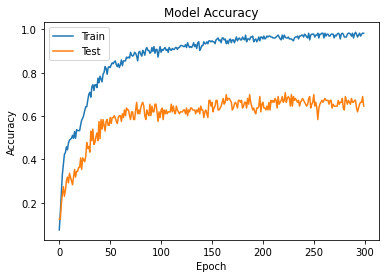

In [ ]:
plt.plot(nn_fitted.history["accuracy"])
plt.plot(nn_fitted.history["val_accuracy"])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
nn_onehot.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 650)               9750      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                31248     
_________________________________________________________________
dense_2 (Dense)              (None, 12)                588       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                390       
Total params: 41,976
Trainable params: 41,976
Non-trainable params: 0
_________________________________________________________________


We note that our initial modelling of y helped us in using the onehot model for our outputs.

In [ ]:
y_test_onehot.shape[1], np.sort(y_train.unique())

(30, array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]))

#### **we note an important remark in this model:**
The number of provided features is only 14, whereas the number of classes that we are predicting is 30 simple leaf kind... 

This suggests that a dimension upscaling is happening in our neural network... It quickly overfits so we must lower the learning rate.

In [ ]:
X.shape[1], y_train_onehot.shape[1]

(14, 30)

In [ ]:
def nn_model_2():
  nn = Sequential()

  size1=20
  nn.add(Dense(size1, activation='sigmoid', kernel_initializer=opt_init(size1), 
               input_dim=input_size))
  
  size2=150
  nn.add(Dense(size2, activation='relu', kernel_initializer=opt_init(size2)))
  
  nn.add(Dense(output_onehot, activation='softmax',
               kernel_initializer=opt_init(output_onehot)))
  
  opt = optimizers.RMSprop(lr=0.0001, rho=0.9,
                           momentum=0.1, decay=1e-6)
  nn.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])
  return nn

In [ ]:
batch_size = 1
epochs = 10

input_size = X_train.shape[1]

y_train_onehot = to_categorical(y_train-1) # minus one since the y in {1..30}
y_test_onehot = to_categorical(y_test-1)
output_onehot = y_test_onehot.shape[1]

nn_onehot_2 = nn_model_2()
nn_fitted_2 = nn_onehot_2.fit(X_train, y_train_onehot,
                          batch_size=batch_size, epochs=epochs,
                          verbose=1, validation_data=(X_test, y_test_onehot))
score_2 = nn_onehot_2.evaluate(X_test, y_test_onehot, verbose=0) 
print('Test accuracy:', score_2[1])

Epoch 1/10
227/227 [==============================] - 1s 2ms/step - loss: 3.5093 - accuracy: 0.0176 - val_loss: 3.3846 - val_accuracy: 0.0442
Epoch 2/10
227/227 [==============================] - 0s 2ms/step - loss: 3.4136 - accuracy: 0.0576 - val_loss: 3.3704 - val_accuracy: 0.0885
Epoch 3/10
227/227 [==============================] - 0s 2ms/step - loss: 3.3607 - accuracy: 0.1309 - val_loss: 3.3583 - val_accuracy: 0.0708
Epoch 4/10
227/227 [==============================] - 0s 1ms/step - loss: 3.3258 - accuracy: 0.0893 - val_loss: 3.3442 - val_accuracy: 0.0708
Epoch 5/10
227/227 [==============================] - 0s 2ms/step - loss: 3.2836 - accuracy: 0.1199 - val_loss: 3.3332 - val_accuracy: 0.0708
Epoch 6/10
227/227 [==============================] - 0s 1ms/step - loss: 3.2456 - accuracy: 0.1020 - val_loss: 3.3243 - val_accuracy: 0.0708
Epoch 7/10
227/227 [==============================] - 0s 1ms/step - loss: 3.2268 - accuracy: 0.1160 - val_loss: 3.3076 - val_accuracy: 0.0885
Epoch 

In [ ]:
batch_size = 10
epochs = 200

input_size = X_train.shape[1]

y_train_onehot = to_categorical(y_train-1) # minus one since the y in {1..30}
y_test_onehot = to_categorical(y_test-1)
output_onehot = y_test_onehot.shape[1]

nn_onehot_2 = nn_model_2()
nn_fitted_2 = nn_onehot_2.fit(X_train, y_train_onehot,
                          batch_size=batch_size, epochs=epochs,
                          verbose=1, validation_data=(X_test, y_test_onehot))
score_2 = nn_onehot_2.evaluate(X_test, y_test_onehot, verbose=0) 
print('Test accuracy:', score_2[1])

Epoch 1/200
23/23 [==============================] - 1s 10ms/step - loss: 3.4662 - accuracy: 0.0474 - val_loss: 3.3919 - val_accuracy: 0.0265
Epoch 2/200
23/23 [==============================] - 0s 3ms/step - loss: 3.4262 - accuracy: 0.0387 - val_loss: 3.3815 - val_accuracy: 0.0265
Epoch 3/200
23/23 [==============================] - 0s 3ms/step - loss: 3.4487 - accuracy: 0.0363 - val_loss: 3.3718 - val_accuracy: 0.0265
Epoch 4/200
23/23 [==============================] - 0s 3ms/step - loss: 3.4007 - accuracy: 0.0394 - val_loss: 3.3624 - val_accuracy: 0.0265
Epoch 5/200
23/23 [==============================] - 0s 4ms/step - loss: 3.3563 - accuracy: 0.0464 - val_loss: 3.3537 - val_accuracy: 0.0265
Epoch 6/200
23/23 [==============================] - 0s 3ms/step - loss: 3.3925 - accuracy: 0.0276 - val_loss: 3.3458 - val_accuracy: 0.0265
Epoch 7/200
23/23 [==============================] - 0s 3ms/step - loss: 3.3306 - accuracy: 0.0429 - val_loss: 3.3383 - val_accuracy: 0.0265
Epoch 8/200


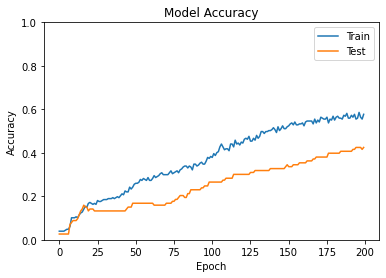

In [ ]:
plt.plot(nn_fitted_2.history["accuracy"])
plt.plot(nn_fitted_2.history["val_accuracy"])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Test'])
plt.show()

We can say that the non-linear predictions of neural networks are not the best on this type of data since the data is mostly linear and varies in a certain limited way, so it is better suited with more linear models.

We now try with a dropout layer of a 20% rate:

In [ ]:
def nn_model_3():
  nn = Sequential()

  nn.add(Dropout(0.2))
  size1=20
  nn.add(Dense(size1, activation='sigmoid', kernel_initializer=opt_init(size1), 
               input_dim=input_size))
  
  nn.add(Dense(output_onehot, activation='softmax',
               kernel_initializer=opt_init(output_onehot)))
  
  opt = optimizers.RMSprop(lr=0.0005, rho=0.9,
                           momentum=0.1, decay=1e-6)
  nn.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])
  return nn

In [ ]:
batch_size = 5
epochs = 600

input_size = X_train.shape[1]

y_train_onehot = to_categorical(y_train-1) # minus one since the y in {1..30}
y_test_onehot = to_categorical(y_test-1)
output_onehot = y_test_onehot.shape[1]

nn_onehot_3 = nn_model_3()
nn_fitted_3 = nn_onehot_3.fit(X_train, y_train_onehot,
                          batch_size=batch_size, epochs=epochs,
                          verbose=1, validation_data=(X_test, y_test_onehot))
score_3 = nn_onehot_3.evaluate(X_test, y_test_onehot, verbose=0) 
print('Test accuracy:', score_3[1])

Epoch 1/600
46/46 [==============================] - 1s 5ms/step - loss: 3.4997 - accuracy: 0.0444 - val_loss: 3.4044 - val_accuracy: 0.0531
Epoch 2/600
46/46 [==============================] - 0s 2ms/step - loss: 3.4638 - accuracy: 0.0666 - val_loss: 3.3763 - val_accuracy: 0.0265
Epoch 3/600
46/46 [==============================] - 0s 2ms/step - loss: 3.3890 - accuracy: 0.0656 - val_loss: 3.3515 - val_accuracy: 0.0354
Epoch 4/600
46/46 [==============================] - 0s 2ms/step - loss: 3.3968 - accuracy: 0.0466 - val_loss: 3.3305 - val_accuracy: 0.0708
Epoch 5/600
46/46 [==============================] - 0s 3ms/step - loss: 3.3162 - accuracy: 0.0884 - val_loss: 3.3093 - val_accuracy: 0.0708
Epoch 6/600
46/46 [==============================] - 0s 2ms/step - loss: 3.3179 - accuracy: 0.0951 - val_loss: 3.2888 - val_accuracy: 0.0708
Epoch 7/600
46/46 [==============================] - 0s 2ms/step - loss: 3.2654 - accuracy: 0.0881 - val_loss: 3.2706 - val_accuracy: 0.0708
Epoch 8/600
4

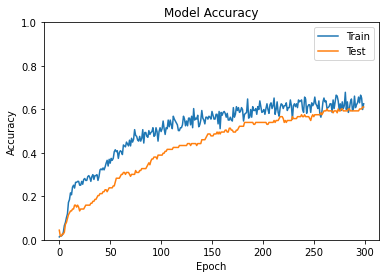

In [ ]:
plt.plot(nn_fitted_3.history["accuracy"])
plt.plot(nn_fitted_3.history["val_accuracy"])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
#quick data refresh
X = df[df.columns[2:]]
y = df[df.columns[0]]
if max(y) > 30:
  y[np.where(y>21)[0]] -= 6
X, y = shuffle(X,y)
X = preprocessing.StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [ ]:
def nn_model_4():
  nn = Sequential()

  nn.add(Dropout(0.2))
  size1=20
  nn.add(Dense(size1, activation='relu', kernel_initializer=opt_init(size1), 
               input_dim=input_size))
  
  nn.add(Dense(output_onehot, activation='softmax',
               kernel_initializer=opt_init(output_onehot)))
  
  opt = optimizers.RMSprop(lr=0.0001, rho=0.9,
                           momentum=0.1, decay=1e-6)
  nn.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])
  return nn

In [ ]:
batch_size = 5
epochs = 4

input_size = X_train.shape[1]

y_train_onehot = to_categorical(y_train-1) # minus one since the y in {1..30}
y_test_onehot = to_categorical(y_test-1)
output_onehot = y_test_onehot.shape[1]

nn_onehot_4 = nn_model_4()
nn_fitted_4 = nn_onehot_4.fit(X_train, y_train_onehot,
                          batch_size=batch_size, epochs=epochs,
                          verbose=1, validation_data=(X_test, y_test_onehot))
score_4 = nn_onehot_4.evaluate(X_test, y_test_onehot, verbose=0) 
print('Test accuracy:', score_4[1])

Epoch 1/4
46/46 [==============================] - 1s 5ms/step - loss: 3.4822 - accuracy: 0.0401 - val_loss: 3.4792 - val_accuracy: 0.0088
Epoch 2/4
46/46 [==============================] - 0s 2ms/step - loss: 3.4863 - accuracy: 0.0552 - val_loss: 3.4607 - val_accuracy: 0.0088
Epoch 3/4
46/46 [==============================] - 0s 2ms/step - loss: 3.4545 - accuracy: 0.0587 - val_loss: 3.4418 - val_accuracy: 0.0177
Epoch 4/4
46/46 [==============================] - 0s 2ms/step - loss: 3.5049 - accuracy: 0.0386 - val_loss: 3.4235 - val_accuracy: 0.0177
Test accuracy: 0.017699114978313446


In [ ]:
batch_size = 5
epochs = 4

input_size = X_train.shape[1]

y_train_onehot = to_categorical(y_train-1) # minus one since the y in {1..30}
y_test_onehot = to_categorical(y_test-1)
output_onehot = y_test_onehot.shape[1]

nn_onehot_4 = nn_model_4()
nn_fitted_4 = nn_onehot_4.fit(X_train, y_train_onehot,
                          batch_size=batch_size, epochs=epochs,
                          verbose=1, validation_data=(X_test, y_test_onehot))
score_4 = nn_onehot_4.evaluate(X_test, y_test_onehot, verbose=0) 
print('Test accuracy:', score_4[1])

Epoch 1/4
46/46 [==============================] - 1s 10ms/step - loss: 3.5251 - accuracy: 0.0416 - val_loss: 3.3866 - val_accuracy: 0.0177
Epoch 2/4
46/46 [==============================] - 0s 2ms/step - loss: 3.3712 - accuracy: 0.0506 - val_loss: 3.3703 - val_accuracy: 0.0265
Epoch 3/4
46/46 [==============================] - 0s 3ms/step - loss: 3.4057 - accuracy: 0.0468 - val_loss: 3.3549 - val_accuracy: 0.0265
Epoch 4/4
46/46 [==============================] - 0s 2ms/step - loss: 3.3810 - accuracy: 0.0713 - val_loss: 3.3390 - val_accuracy: 0.0265
Test accuracy: 0.02654867246747017


As we can see, we tried different neural networks and in the end, the best accuracy we achieved using neural networks was 0.8 with SVC . It is important to note that there was one last idea that we tried to implement but the algorthims to accomplish this is out of scope of this course. The idea was inspired from a research paper. The idea is to transform the leaves using the features that specify some geometric characteristic about the leaf to a 2D paintings, and then test convolutional neural networks on the leafs. From the research paper, the usage of such a technique should provide us with a test accuracy of somewhere over 90%, but we can't be sure unless we try it.
Also after running all these classifiers multiple times, we realized that values greatly differ from one run to another which shows that the accuracy vary greatly with the training and testing samples that we took. So with each different sample, accuracies vary greatly.